In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 
import scipy.optimize as optimize

import warnings

warnings.filterwarnings("ignore")
i   = np.complex(0.0,1.0)


In [2]:
# This class defines puts and calls

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
# Black-Scholes call option price

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

# Implied volatility method

def ImpliedVolatility(CP,marketPrice,K,T,S_0,r,initialVol = 0.4):
    func = lambda sigma: np.power(BS_Call_Option_Price(CP,S_0,K,sigma,T,r) \
                                  - marketPrice, 1.0)
    impliedVol = optimize.newton(func, initialVol, tol=1e-7)
    
    return impliedVol

def MertonCallPrice(CP,S0,K,r,tau,muJ,sigmaJ,sigma,xiP):
    X0  = np.log(S0)

    # Term for E(exp(J)-1)

    helpExp = np.exp(muJ + 0.5 * sigmaJ * sigmaJ) - 1.0
           
    # Analytic representation for the Merton model option price

    muX     = lambda n: X0 + (r - xiP * helpExp - 0.5 * sigma * sigma) \
    * tau + n * muJ
    sigmaX  = lambda n: np.sqrt(sigma * sigma + n * sigmaJ * sigmaJ / tau) 
    d1      = lambda n: (np.log(S0/K) + (r - xiP * helpExp - 0.5*sigma * sigma \
            + np.power(sigmaX(n),2.0)) * tau + n * muJ) / (sigmaX(n) * np.sqrt(tau))
    d2      = lambda n: d1(n) - sigmaX(n) * np.sqrt(tau)
    value_n = lambda n: np.exp(muX(n) + 0.5*np.power(sigmaX(n),2.0)*tau)\
            * st.norm.cdf(d1(n)) - K *st.norm.cdf(d2(n))
    
    # Option value calculation, it is an infinite sum but we truncate at 20

    valueExact = value_n(0.0)
    kidx = range(1,20)
    for k in kidx:
        valueExact += np.power(xiP * tau, k)*value_n(k) / np.math.factorial(k)
    valueExact *= np.exp(-r*tau) * np.exp(-xiP * tau)
    return valueExact


def mainCalculation():
    CP  = OptionType.CALL
    S0  = 100
    r   = 0.0
    tau = 2
    
    K = np.linspace(40,180,25)
    K = np.array(K).reshape([len(K),1])

    sigma  = 0.25
    muJ    = 0.0
    sigmaJ = 0.2
    xiP    = 0.1
     
    # Effect of sigmaJ

    plt.figure(1)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    sigmaJV =[0.0, 0.1, 0.2, 0.3, 0.4]
    legend = []
    for sigmaJtemp in sigmaJV:    

        # Evaluate the Merton model

        valueExact = MertonCallPrice(CP,S0,K,r,tau,muJ,sigmaJtemp,sigma,xiP)
        
        # Implied volatilities

        IV =np.zeros([len(K),1])
        for idx in range(0,len(K)):
            IV[idx] = ImpliedVolatility(CP,valueExact[idx],K[idx],tau,S0,r)
        plt.plot(K,IV)
        legend.append('sigma_J={0}'.format(sigmaJtemp))
    plt.legend(legend)
    
      # Effect of xi_P

    plt.figure(2)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    #sigmaJ = 0.25
    #muJ    = 0.0
    xiPV   = [0.0, 0.25, 0.5, 0.75, 1.0]
    legend = []
    for xiPtemp in xiPV:    

        # Evaluate the Merton model

        valueExact = MertonCallPrice(CP,S0,K,r,tau,muJ,sigmaJ,sigma,xiPtemp)
        
        # Implied volatilities

        IV =np.zeros([len(K),1])
        for idx in range(0,len(K)):
            IV[idx] = ImpliedVolatility(CP,valueExact[idx],K[idx],tau,S0,r,0.3)
        
        #plt.figure()
        plt.plot(K,IV)
        legend.append('xiP={0}'.format(xiPtemp))
    plt.legend(legend)
    
     # Effect of mu_J

    plt.figure(3)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    #sigmaJ = 0.25
    #xiP    = 0.5
    muJV = [-0.25, -0.05, 0.1, 0.25, 0.4]
    legend = []
    for muJtemp in muJV:    

        # Evaluate the Merton model

        valueExact = MertonCallPrice(CP,S0,K,r,tau,muJtemp,sigmaJ,sigma,xiP)
        
        # Implied volatilities

        IV =np.zeros([len(K),1])
        for idx in range(0,len(K)):
            IV[idx] = ImpliedVolatility(CP,valueExact[idx],K[idx],tau,S0,r)
        plt.plot(K,IV)
        legend.append('mu_J={0}'.format(muJtemp))
    plt.legend(legend)

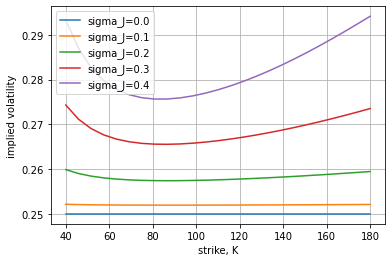

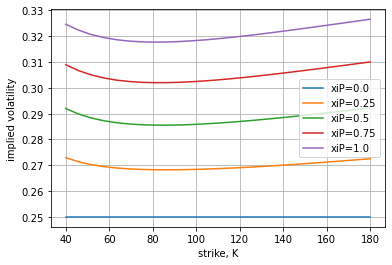

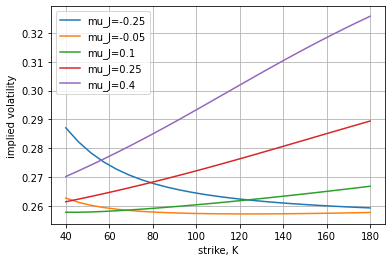

In [3]:
mainCalculation()